In this project, we will be putting recommendation skills to use on real data from the IBM Watson Studio Platform

Below is the map for this project execution:

- Exploratory Data Analysis
- Rank Based Recommendation System
- User-User Based Collaborative Filtering
- Matrix Factorization
- Conclusion

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline 

df = pd.read_csv('/Users/harshitchandrol/Documents/PORTFOLIO/ML/Recommendation Engine/user-item-interactions.txt')
df_content = pd.read_csv('/Users/harshitchandrol/Documents/PORTFOLIO/ML/Recommendation Engine/articles_community.txt')

df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [8]:
del df['Unnamed: 0']
del df_content['Unnamed: 0']
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [9]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## Exploratory Data Analysis

#### 1. What is the distribution of how many articles a user interacts with in the dataset?

In [10]:
# shapes of the dataframes
print(df.shape)
print(df_content.shape)

(45993, 3)
(1056, 5)


In [11]:
# distribution of the user interactions with articles
dist_interactions = df.groupby('email')['article_id'].count()
dist_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

(array([4.285e+03, 4.350e+02, 1.950e+02, 8.900e+01, 5.500e+01, 2.300e+01,
        2.800e+01, 1.100e+01, 7.000e+00, 2.000e+00, 2.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1. ,  13.1,  25.2,  37.3,  49.4,  61.5,  73.6,  85.7,  97.8,
        109.9, 122. , 134.1, 146.2, 158.3, 170.4, 182.5, 194.6, 206.7,
        218.8, 230.9, 243. , 255.1, 267.2, 279.3, 291.4, 303.5, 315.6,
        327.7, 339.8, 351.9, 364. ]),
 <BarContainer object of 30 artists>)

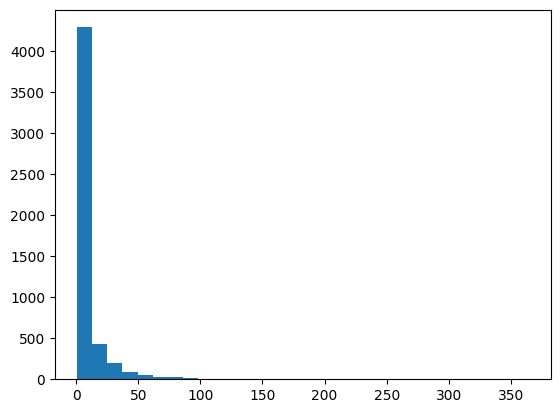

In [19]:
# histogram of the article interactions
plt.hist(dist_interactions, bins=30)

In [21]:
# median and maximum number of user_articles interaction

median_val=dist_interactions.median()
max_views_by_user = dist_interactions.max()

In [22]:
print(median_val)
print(max_views_by_user)

3.0
364


50% of the users interact with 3 articles or fewer.

the maximum number of user_articles interactions by any.1 user is 364

#### 2. Explore and remove duplicate articles from the df_content dataframe.

In [24]:
# finding duplicate articles
# any rows that are completely duplicate
print('Complete Duplicates',df_content.duplicated().sum())

# any rows that have same name
print('duplicate names', df_content.duplicated(['doc_full_name']).sum())
# any rows that have the same doc description
print('duplicate descriptions', df_content.duplicated(['doc_description']).sum())
# any rows that have the same doc body
print('duplicate body', df_content.duplicated(['doc_body']).sum())
# any rows that have the same article id
print('duplicate id', df_content.duplicated(['article_id']).sum())

Complete Duplicates 0
duplicate names 5
duplicate descriptions 33
duplicate body 19
duplicate id 5


In [25]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

# check whether duplicates were successfully removed
print('duplicate id', df_content.duplicated(['article_id']).sum())

duplicate id 0


#### 4.  The number of duplicated articles that have an interaction with the user

In [26]:
# number of unique articles that have at least one interaction
more_than_1_interaction = len(df.groupby('article_id')['email'].unique())
print('unique articles with at least one interaction', more_than_1_interaction)

unique articles with at least one interaction 714


In [28]:
# number of unique articles on platform
total_articles = len(df_content)
print('unique articles in total', total_articles)

unique articles in total 1051


In [29]:
# unique number of users
unique_users = df['email'].nunique()
print('unique users', unique_users)

unique users 5148


In [30]:
# user-article interactions
user_article_interactions = len(df)
print('user-article interactions', user_article_interactions)

user-article interactions 45993


In [33]:
unique_articles = more_than_1_interaction # The number of unique articles that have at least one interaction
total_articles = total_articles # The number of unique articles on the IBM platform
unique_users = unique_users # The number of unique users
user_article_interactions = user_article_interactions# The number of user-article interactions

In [34]:
# get the article_id of the most viewed article
most_viewed_article = str(df['article_id'].value_counts().index[:1][0])
print('most viewed article id', most_viewed_article)

most viewed article id 1429.0


In [35]:
# get the number of views of the most viewed article
num_views_most = df['article_id'].value_counts().values[:1][0]
print('number of views of most viewed article', num_views_most)

number of views of most viewed article 937


In [36]:
# assigning the previously calculated values
most_viewed_article_id = most_viewed_article # The most viewed article in the dataset as a string with one value following the decimal 
max_views = num_views_most # The most viewed article in the dataset was viewed how many times?

In [37]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


## Rank Based Recommendation System

we don't actually have ratings for whether a user liked an article or not. We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

Lets write a function to return n top articles ordered with most interactions as the top.

In [40]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_ids = df['article_id'].value_counts()
    
    top_articles = []
    for val in top_ids.index[:n]:
        top_articles.append(df.loc[df['article_id'] == val, 'title'].iloc[0])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list(df['article_id'].value_counts().index[:n])
 
    return top_articles # Return the top article ids

In [41]:
# printing the top articles
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


## User-User Based Collaborative Filtering

Lets create a matrix,
- Each user should only appear in each row once.
- Each article should only show up in one column.
- If a user has interacted with an article, then place a 1 where the user-row meets for that article-column. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.
- If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.

In [42]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_no_title = df.drop(['title'], axis=1)
    
    # add column with only 1s that will be converted to values for each user and article crossing
    df['count'] = 1
    user_item = df.groupby(['user_id', 'article_id'])['count'].max().unstack()
    
    user_item = user_item.replace(np.nan, 0)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

Let us create the function which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [44]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
   # compute similarity of each user to the provided user
    similarity = []
    for user in range(1, user_item.shape[0]+1):
        similar = np.dot(user_item.loc[user_id], user_item.loc[user])
        similarity.append((user, similar))

    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)

    # create list of just the ids
    most_similar_users = [tup[0] for tup in similarity]

    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
       

In [45]:
#a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommenf/

In [46]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for article in article_ids:
        article_title = df[df['article_id'] == float(article)].max()['title']
        article_names.append(article_title)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # get all values in Series format for a user from the user_item matrix
    user_series = user_item.loc[user_id]
    # select only index-value pairs where the value is equal to 1
    article_ids = list(user_series[user_series == 1].index)
    article_ids = [str(single_id) for single_id in article_ids]
    
    # get the article names for the list of article ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    current_user_article_ids, current_users_article_names = get_user_articles(user_id)
    
    recs = []
    # looping through list of all users sorted by similarity to user_id
    for user in similar_users:
        # get the list of article ids and names of each user
        article_ids, article_names = get_user_articles(user)
        # remove any article from the similar user's article list that user_id has read already
        new_articles = [x for x in article_ids if x not in current_user_article_ids]
        # append all articles that are left to the recommendation list
        for article_id in article_ids:
            recs.append(article_id)
        if len(article_ids) > m:
            break
    
    return recs[:m] # return your recommendations for this user_id 

In [47]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'introducing ibm watson studio ',
 'python for loops explained (python for data science basics #5)',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities']

Now we are going to improve the consistency of the user_user_recs function from above.

- Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

- Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the top_articles function you wrote earlier.

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create empty datafram
    columns = ['neighbor_id']
    neighbors_df = pd.DataFrame(columns=columns)

    # find_similar_users function to determine most similar users and add the results in the neighbor_id column
    neighbors_df['neighbor_id'] = find_similar_users(user_id)
    
    # calculate the similarity between users with the dot product
    similarity = user_item[user_item.index == user_id].dot(user_item.T).transpose()
    similarity.rename({user_id: 'similarity'}, axis=1, inplace=True)
    # merge the similarit
    neighbors_df = neighbors_df.merge(similarity, left_on='neighbor_id', right_on='user_id')

    num_interactions_df = pd.DataFrame(user_item.sum(axis=1), columns=['num_interactions'])
    neighbors_df = neighbors_df.merge(num_interactions_df, left_on='neighbor_id', right_on='user_id')

    neighbors_df.sort_values(['similarity', 'neighbor_id', 'num_interactions'], ascending=[False, True, False], inplace=True)
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get the top read articles and save them to a dataframe
    top_articles = df['article_id'].value_counts()
    top_articles_df = pd.DataFrame({'article_id': top_articles.index.astype(str), 'num_reads': top_articles.values})
    
    # get dataframe containing the sorted most similar users of user_id
    neighbors_df = get_top_sorted_users(user_id)
    # get the list of articles of user_id
    current_user_article_ids, current_user_article_names = get_user_articles(user_id)
    # instantiate empty list to store recommended article ids
    recs = []

    # loop through all rows of the neighbors_df and find recommendations for user_id
    for index, row in neighbors_df.iterrows():
        # get the list of article ids and names of each user
        article_ids, article_names = get_user_articles(row['neighbor_id'])
        # remove any article from the similar user's article list that user_id has read already
        new_articles = [x for x in article_ids if x not in current_user_article_ids]
        # sort the new_articles by the number of total interactions per article
        new_articles_df = pd.DataFrame(new_articles, columns=['article_id'])
        sorted_articles_df = new_articles_df.merge(top_articles_df, how='left', on='article_id')
        sorted_articles_df.sort_values(['num_reads'], ascending=False, inplace=True)
        
        # append all articles that are left to the recommendation list
        for article_id in sorted_articles_df['article_id']:
            recs.append(article_id)
        if len(new_articles) > m:
            break
    
    # get the names of the articles based on article ids
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [50]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1162.0', '1304.0', '43.0', '1351.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss']


In [51]:
user1_most_sim = get_top_sorted_users(1)['neighbor_id'][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'][9] # Find the 10th most similar user to user 131

If we have a new user and thus, no reading history of this user, one option would be to just show the top most read articles on the platform. This could be refined if the articles had tags and the user could select tags of interest to them. In this case, we could create a knowledge-based or content-based recommendation system.

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
new_user_recs

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

## Matrix Factorization

We will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('/Users/harshitchandrol/Documents/PORTFOLIO/ML/Recommendation Engine/user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [57]:
# printing the shapes of the new matrices
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


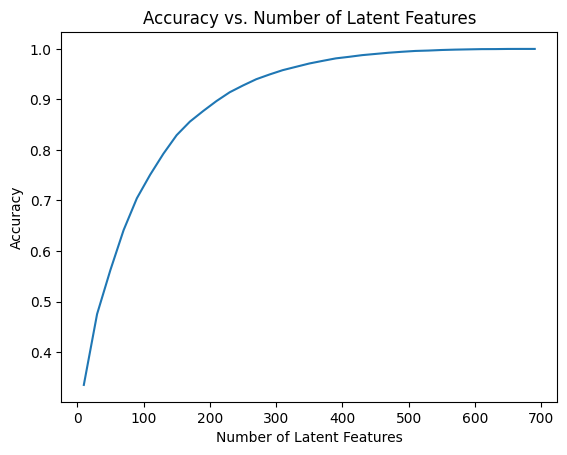

In [58]:
# assigning the iterative range for latent features
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

# plotting accuracy vs. the number of latent features in a graph    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [59]:
# plitting the dataframe into train and test data
df_train = df.head(40000)[:]
df_test = df.tail(5993)[:]

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

# assigning the train and test matrices as well as the test users and articles
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [60]:
# number of users we can make precitions for
pred_users = len(set(user_item_train.index.values).intersection(test_idx))
print(pred_users)

# number of users we cannot make precitions for
no_pred_users = len(test_idx) - pred_users
print(no_pred_users)

# number of articles we can make predictions for
pred_articles = len(set(user_item_train.columns.values).intersection(test_arts))
print(pred_articles)

# number of articles we cannot make predictions for
no_pred_articles = len(test_arts) - pred_articles
print(no_pred_articles)

20
662
574
0


In [61]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [62]:
# printing the shapes of the new matrices
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [63]:
# finding subsets of rows in user_item_test dataset

# all users and all articles in the train dataset
train_idx = user_item_train.index.values
train_arts = user_item_train.columns.values

# subset of train data also in user_item_test matrix: boolean values
test_train_idx_bool = user_item_train.index.isin(test_idx)
test_train_arts_bool = user_item_train.columns.isin(test_arts)

# subset of train data also in user_item_test matrix: actual values
test_train_idx = np.intersect1d(train_idx, test_idx) 
test_train_arts = set(train_arts).intersection(set(test_arts))

# subsets of the user_item_test matrix
user_item_test_subset = user_item_test.loc[test_train_idx]

# get SVD values for the test items
u_test = u_train[test_train_idx_bool, :]
s_test = s_train
vt_test = vt_train[:, test_train_arts_bool]

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

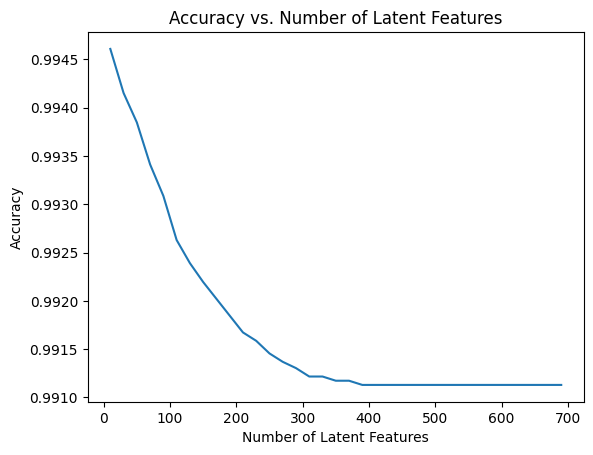

In [64]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_test_k, u_test_k, vt_test_k = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_test_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# plotting accuracy vs. the number of latent features    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')

To check the different recommendation systems I implemented in the above steps (rank-based, collaborative filter, and matrix factorization), I could create an A/B experiment with each of these recommendation engines. Group A could be the very basic rank-based system and our control group (if there is no other engine implemented on IBM Watson yet) and use collaborative filtering as group B.

My null hypothesis would be:

H0: mean_b <= mean_a

H1: mean_b > mean_a

A user visiting IBM Watson would then be randomly assigned either to group A or group B and over a certain period of time, we could measure how well our systems are recommending relevant content to the user.

There are a number of different factors that would need to be determined:

1. Unit of diversion:

- event-based diversion
- cookie-based diversion
- account-based diversion --> account-based would probably be the way to go here

2. Evaluation metrics:

- evaluation metrics that measure whether we achieved our goal; example could be
    - ratio of recommended articles read vs. non-recommended articles
    - root mean squared error
    - precision / recall on top n articles
- invariant metrics to check whether our experiment is running as expected (groups have the same size, for example)

3. Experiment Size:

- Determine the minimum number of samples needed to achieve a desired power level (given a true mean (different from null), the probability of rejecting the null hypothesis) for a given effect size

4. Type of test to determine success of experiment:

- Bootstrapping
- Permutation Tests
- Rank-sum test
- Sign test
- Standard hypothesis tests

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Recommendations_with_IBM.ipynb' matched no files


255